<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/Restoration/Networks_for_image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks for image denoising

**References**:
* Code and model from [Tassano et al., An Analysis and Implementation of the FFDNet Image Denoising Method, IPOL, 2019](https://www.ipol.im/pub/art/2019/231/?utm_source=doi). 
* Code and model from [Mohan et al., Robust and interpretable blind image denoising via bias-free convolutional neural networks, 2020](https://arxiv.org/abs/1906.05478v3)

**Authors:**
* [Julie Delon](https://github.com/judelo) 
* Lucía Bouza

## Introduction

In this notebook we focus on one of the most basic inverse problem in image processing, namely image denoising. As a reminder, the problem can be described as estimating an unknown image $x$ from a noisy version $$y = x+n$$ where $n$ is a realization of a random noise with known distribution. For the sake of simplicity, we assume here that the noise distribution is a Gaussian $\mathcal{N}(0,Id)$.   

In the last few years, several convolutional neural networks (CNN) have been proposed in the literature to denoise images (i.e. to recover $x$ from $y$), demonstrating high performance in terms of image quality as well as inference time. These deep denoising networks outperform traditional denoising algorithms, such as patch-based denoising algorithms, but they need long training phases on a large database with energy-intensive GPUs.  

The first really efficient denoising CNN proposed in the literature was probably [DnCNN](https://arxiv.org/abs/1608.03981), proposed by Zhang et al. in 2016. An even more efficient evolution of DnCNN, called [FFDnet](https://arxiv.org/abs/1710.04026) was proposed later by the same authors. This Jupyter notebook relies heavily on the implementation of [FFDnet available on the Image Processing On Line website](https://www.ipol.im/pub/art/2019/231/).  

## FFDNet

[FFDnet](https://arxiv.org/abs/1710.04026) is a recent image denoising method based on a CNN architecture. Recall that convolutional neural networks (CNN) are composed of a succession of convolutional layers with nonlinear activation functions between them. Compared to state-of-the-art traditional denoising methods, FFDNet exhibits several desirable properties such as a fast execution time (even implemented on a CPU) and a small memory footprint, as well as the ability to handle a wide range of noise levels with a single trained model. The combination between its denoising performance and low computational load makes this algorithm attractive for practical denoising applications.

The following scheme shows the basic architecture of the network.

![Text](https://raw.githubusercontent.com/storimaging/Images/main/SupportImages/ArquitectureFFDNet.jpg)

*Architecture of FFDNet (image taken from [Tassano et al, An Analysis and Implementation of the FFDNet Image Denoising Method, IPOL, 2019](https://www.ipol.im/pub/art/2019/231/))*

Compared to DnCNN, FFDNet include additional pre-processing and post-processing layers ($F^0$ and $F^{D+1}$ respectively). 

**The pre-processing layer** rearranges the pixels of an $nch × h × w$ input image $I$ into a lower resolution image of size $4nch × h/2 × w/2$. The layer extracts $2 × 2$ patches and rearranges their pixels in the different channels as it is shown in the image below.  An additional channel of the same resolution composed of an estimate of the noise map $M$ is added to the input. This noise map controls the trade-off between denoising and detail preservation. For spatially invariant Gaussian noise with standard deviation σ, the noise map is uniform with all its elements equal to σ.

Most of the computations are performed at this lower scale. A consequence is that for a given network depth, the receptive field of a given pixel in the output image is larger than it would be by working with the original scale.

![Text](https://raw.githubusercontent.com/storimaging/Images/main/SupportImages/downscalingLayerFFDNet.jpg)

*Diagram of the downscaling layer (image taken from [Tassano et al, An Analysis and Implementation of the FFDNet Image Denoising Method, IPOL, 2019](https://www.ipol.im/pub/art/2019/231/)).*

**The nonlinear mapping** is composed of $D$ convolutional layers (layers $F^1$ . . . $F^D$), where $D$ is set to 15 for grayscale denoising, and 12 for color denoising. 
Each of these layers consists of $W$ convolutional filters of spatial size $K × K$, where $K$ is set to 3 and $W$ is set to 64 and 96 for grayscale and color denoising, respectively.
The outputs of layers $F^1$ to $F^{D-1}$ are followed by point-wise ReLU activation functions ($ReLU(·) = max(·,0)$). At training time, batch normalization layers are placed between the convolutional and ReLU layers in $F^2$ to $F^{D−1}$. At evaluation time, the batch normalization layers are removed, and replaced by an affine layer that applies the learned normalization.

Note that the network designed for color denoising is shallower ($D_{RGB} < D_{gray}$) but wider ($W_{RGB} > W_{gray}$) than the grayscale denoising network. This increased width contributes to a better color consistency in the results as the correlations between the color channels are better treated by the network.

**The post-processing layer** reshapes the output of the nonlinear mapping back into the original input resolution ($nch × h × w$).

![Text](https://raw.githubusercontent.com/storimaging/Images/main/SupportImages/upscalingLayerFFDNet.jpg)

*Diagram of the upscaling layer (image taken from [Tassano et al, An Analysis and Implementation of the FFDNet Image Denoising Method, IPOL, 2019](https://www.ipol.im/pub/art/2019/231/)).*

In summary, the architecture is composed of:
- A pre-processing layer.
- $D$ convolutional layers where $D-2$ of them are followed by a batch normalization layers.
- A post-processing layer.

Since $D$ is set to 15 for grayscale denoising, and 12 for color denoising, the total number of layers for the grayscale denoising network is 26 and 20 for the color denoising network. 
The number of learnable parameters of the color denoising network is $8.5 × 10^5$ and the grayscale network $5.6 × 10^5$ .

### Training

The previous network represents a parametric function $F_\theta(y)$, which depends on a set of parameters $\theta$ and take as input the image to be denoised $y$.

The network is trained on a set of image pairs $(x_i,y_i)$, $x_i$ being the original image and $y_i$ its noisy version, and we look for $\hat{\theta}$ which minimizes the quadratic loss
$$\theta \mapsto \sum_i \|F_{\theta}(y_i) - x_i\|^2.$$

To this aim, training and validation datasets are created by extracting patches from a given dataset of images. These two datasets are therefore collections of patches $x_i$, and noise is added to these $x_i$'s to create the $y_i$'s. In the FFDnet version that will be used here, the standard deviation of the noise used in the training phase spans the range $[0,75]$. 

If residual learning is used, the network outputs an estimate of the input noise. Then, the denoised image is computed by subtracting the output noise from the noisy input. Models without residual learning directly estimate the denoised image. Models using residual learning are considered as easier to train.

### Use pre-trained model for denoising

In this notebook, for the sake of simplicity (and computing time!), we will use a pre-trained version of FDDNet, presented in [Tassano et al., An Analysis and Implementation of the FFDNet Image Denoising Method, IPOL, 2019](https://www.ipol.im/pub/art/2019/231/?utm_source=doi). 

Observe that the [demo](https://ipolcore.ipol.im/demo/clientApp/demo.html?id=231&key=EC9759C56D1F26425382B44D969DB42E#) section of the IPOL paper can be used as another way to easily experiment with FFDnet.

### Importing packages

Below is a list of basic packages needed to manipulate images and measure the algorithm performances. PyTorch version used to run this notebook is **1.11.0+cu113** (to check the installed version, use `torch.__version__`)

- `numpy`
- `matplotlib` (display of images and graphics)
-  `os` (interactions with the operating system)
-  `torch` (to use cuda with PyTorch)

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

### Set a device

Next, we need to choose which device (CPU or GPU) will be used to run the algorithm, using the function `torch.device`. We use `torch.cuda.is_available()` to detect if there is a GPU available.  In the following sections, the `.to(device)` method is used to move tensors or modules to a desired device.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
!nvidia-smi

### Performance measurement

To measure the time spent, we will use the time function before and after the execution of the algorithm. To measure the performance of the algorithm, we will use the PSNR metric. Peak represents the maximum value the signal can get.

In [ ]:
def PSNR(image_u, image_denoised, peak=1):
    
    return 10*np.log10(peak**2/np.mean((image_u-image_denoised)**2))

### Download code and models

The following cell is executed to download the code and the model from the IPOL server. Observe that memory weight of the whole denoising network is just a few Mo, far below classification networks used in computer vision. Denoising networks are much smaller.

In [ ]:
!wget -c https://www.ipol.im/pub/art/2019/231/ffdnet-pytorch.zip
!unzip ffdnet-pytorch.zip

In [ ]:
cd ffdnet-pytorch

/content/ffdnet-pytorch


Next all the packages required by the script will be installed. These are listed on `requirements.txt` and can be installed with the commented line below. If you use Google colab, running this line is not needed, since almost all the requirements are already met, but if you are running locally please uncomment the first line.

In [ ]:
#!pip install -r requirements.txt
!pip uninstall -y imgaug albumentations
!pip install scikit-image==0.15.0  # sci-kit image is needed by the IPOL version of FFDnet 

### Running the script

We will use the script `test_ffdnet_ipol.py` to denoise an image. Pre-trained models are located in the *models* folder.


The script format should be:
```
python test_ffdnet_ipol.py \
	--input <IMAGE> \
	--noise_sigma <value> \
	--add_noise <TRUE|FALSE>
```
To run the algorithm on a CPU instead of a GPU, use:
```
python test_ffdnet_ipol.py \
	--input <IMAGE> \
	--noise_sigma <value> \
	--add_noise <TRUE|FALSE>
	--no_gpu
```
**REMARKS**
* Models were trained for noise standard deviations ​​in the range $[0, 75]$
* *add_noise* can be set to *False* if the input image is already noisy.
* The code provides an image to test (*input.png*), but it can be replaced by any other image. 
* The resulting denoised image can be found in the folder with the name *ffdnet.png*

Let's start by executing the script with an image provided with the network. A noise of standard deviation $50$ is added to the original image.

In [ ]:
start = time.time()
!python test_ffdnet_ipol.py --input input.png --add_noise True --noise_sigma 50
end = time.time()


### Testing FFDNet model ###
> Parameters:
	add_noise: True
	input: input.png
	suffix: 
	noise_sigma: 0.19607843137254902
	dont_save_results: False
	no_gpu: False
	cuda: True


rgb: True
im shape: (518, 774, 3)
Loading model ...



In the following, we display the denoised image and compare with the input image. We also display the PSNR of the resulting denoised image.

In [ ]:
def printImages(u,v,vdenoised):
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    axes[0].set_title('original image')
    axes[0].imshow(u,cmap='gray',vmin=0,vmax=1)
    axes[1].set_title('Noisy image')
    axes[1].imshow(v,cmap='gray',vmin=0,vmax=1)
    axes[2].set_title('Denoised image')
    axes[2].imshow(vdenoised,cmap='gray',vmin=0,vmax=1)
    fig.tight_layout()
    plt.show()

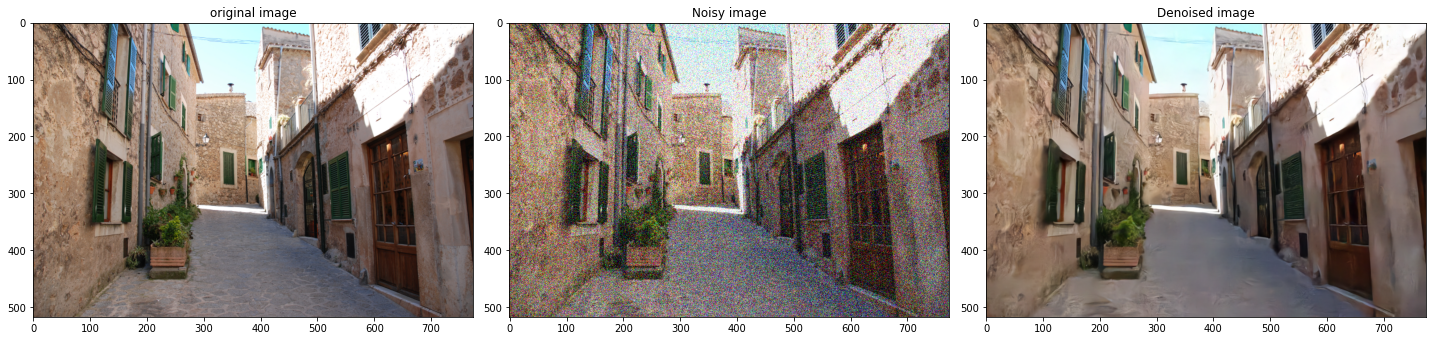

time:  17.189833641052246
PSNR:  27.651062469246234


In [ ]:
# Load and print images
original = plt.imread('input.png')
noisy = plt.imread('noisy.png')
denoised = plt.imread('ffdnet.png')

printImages(original,noisy,denoised)

# Print Statistics
print("time: ", end - start)
print("PSNR: ", PSNR(original, denoised))

A second version of the FFDnet network trained on gray level images is also provided and tested below on the *Simpson* image.


In [ ]:
!wget -c "https://raw.githubusercontent.com/storimaging/Images/main/img/simpson.png"

start = time.time()
!python test_ffdnet_ipol.py  --input simpson.png --add_noise True --noise_sigma 50
end = time.time()

--2022-09-29 08:33:03--  https://raw.githubusercontent.com/storimaging/Images/main/img/simpson.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 505220 (493K) [image/png]
Saving to: ‘simpson.png’

simpson.png         100%[===================>] 493.38K  --.-KB/s    in 0.04s   

2022-09-29 08:33:03 (13.3 MB/s) - ‘simpson.png’ saved [505220/505220]


### Testing FFDNet model ###
> Parameters:
	add_noise: True
	input: simpson.png
	suffix: 
	noise_sigma: 0.19607843137254902
	dont_save_results: False
	no_gpu: False
	cuda: True


rgb: False
im shape: (1024, 1024)
Loading model ...



Comparison of the three images (original, noisy and denoised).

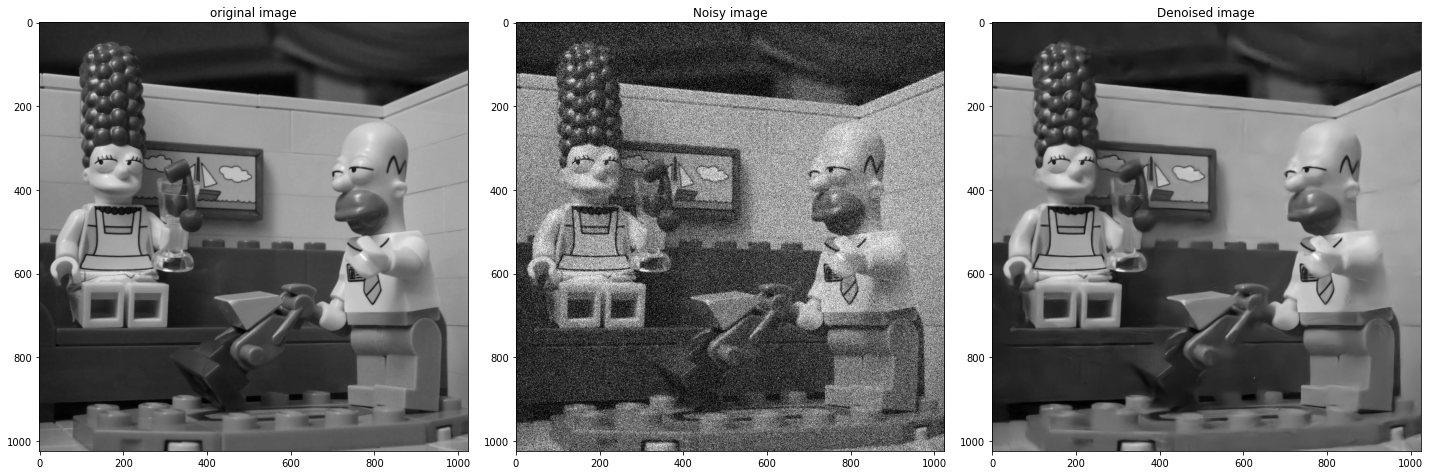

time:  6.350380897521973
PSNR:  33.34581412610847


In [ ]:
# Load and print images
original = plt.imread('simpson.png')
noisy = plt.imread('noisy.png')
denoised = plt.imread('ffdnet.png')

printImages(original,noisy,denoised)

# Print Statistics
print("time: ", end - start)
print("PSNR: ", PSNR(original, denoised))

### Comparison with traditional patch-based methods

For the sake of comparison, we provide below the denoising results obtained with two traditional patch-based methods on the same *Simpson* image, at the same noise level.  


**PCA-based denoising**


![Text](https://raw.githubusercontent.com/storimaging/Images/main/SupportImages/DebruitePCA.jpg)

Restoration made with the notebook [Non local approaches for image denoising](https://colab.research.google.com/github/storimaging/Notebooks/blob/main/Restoration/Non_local_approaches_for_image_denoising.ipynb)

**Non Local means with Integral images (Pytorch)**

![Text](https://raw.githubusercontent.com/storimaging/Images/main/SupportImages/NLMeansPytorch.jpg)

Restoration made with the notebook [Non local means for denoising](https://colab.research.google.com/github/storimaging/Notebooks/blob/main/Restoration/Non_Local_Means_for_denoising.ipynb)

It is also interesting to study the performance of the algorithm when running on CPU instead of GPU. We will add the corresponding flag to the `test_ffdnet_ipol.py` script to not use the available GPU.

In [ ]:
start = time.time()
!python test_ffdnet_ipol.py  --input simpson.png --add_noise True --noise_sigma 50 --no_gpu
end = time.time()

denoised = plt.imread('ffdnet.png')

# Print Statistics
print("time: ", end - start)
print("PSNR: ", PSNR(original, denoised))


### Testing FFDNet model ###
> Parameters:
	add_noise: True
	input: simpson.png
	suffix: 
	noise_sigma: 0.19607843137254902
	dont_save_results: False
	no_gpu: True
	cuda: False


rgb: False
im shape: (1024, 1024)
Loading model ...

time:  6.6502602100372314
PSNR:  33.289859847057


We see that FFDnet clearly outperforms NLmeans and the PCA-based approach, for a comparable computation time, even if running on CPU. 

## Generalization capacity

An important question regarding neural netwoks concerns their **generalization capacity**. As explained above, FFDnet is trained on a patch dataset, adding noise with standard deviations spanning the range $[0,75]$. In the following, we illustrate the behavior of the network outside of this noise range.  

To this aim, we plot the PSNR of the denoised images for different noise levels $\sigma$, both inside and outside the training range.

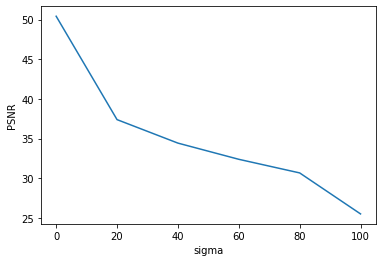

In [ ]:
psnr_list = []
original = plt.imread('simpson.png')

for sigma in range(0, 120, 20):   
    os.system("python test_ffdnet_ipol.py --input simpson.png --add_noise True --noise_sigma " + str(sigma))
    denoised = plt.imread('ffdnet.png')
    psnr_list.append(PSNR(original, denoised))

plt.plot(range(0,120,20), psnr_list)
plt.xlabel('sigma')
plt.ylabel('PSNR')
plt.show()

As it could be expected, the higher the noise level, the lower the performance, regardless of the range $\sigma$. However, from $\sigma= 75$ we can see that the performance drops more drastically. This means that the model fails to generalize to noise levels not observed in the training.

The paper [Mohan et al., Robust and interpretable blind image denoising via bias-free convolutional neural networks, 2020](https://arxiv.org/abs/1906.05478v3) shows that generalization can be achieved by simply removing (before training) the bias from CNN architectures.

## Bias free networks

Suppose we have a CNN $f$ and an input image $y$. Convolutional neural networks using RELU as an activation function implement piecewise affine functions, so the output of the network $f(y)$ can be written $$f(y) = A_y y + b_y,$$ where $A_y$ is the Jacobian of $f(·)$ evaluated at input $y$ and $b_y$ represents the net bias. $A_y$ and $b_y$ will depend on the input, activation functions and network weights. 

Then we can define the residual (or error) of the network as: 
$y - f(y) = (Id - A_y)y - b_y$. 

Experiments done on the paper show that when the noise level of the input image is included in the training range, $b_y$ is small, so $A_y$ is responsible for most of the denoising. However, when the network is evaluated at noise levels outside of the training range, the norm of the bias increases, and the residual is significantly smaller than the noise, suggesting some form of overfitting. The proposal is therefore to remove all bias terms from all stages of the network. 

The authors of the paper have done several experiments with CNN networks (in particular DnCNN) and found that the same networks without bias perform better than the original architectures.  This can be explained very simply: networks without bias encode homogeneous functions (functions $f$ for which $f(\lambda x) = \lambda f(x)$ for $\lambda > 0$), so if $f$ learns to denoise $x$ at level $\sigma$, then $f$ can also denoise $x$ at level $\lambda \sigma$ by denoising $x / \lambda$ at level $\sigma$.


### Experiments with bias free networks

In the next section, we will use a bias free network (called BF-CNN) to denoise an image with a noise level outside the training range. We will use the [github implementation](https://github.com/LabForComputationalVision/bias_free_denoising.git) provided by the authors, as well as the pretrained models. 

#### Demo provided by the authors

In this section, we use the functions and datasets provided by the authors to perform denoising and comparison with biased networks. The following experiments are inspired by this [colab notebook](https://github.com/LabForComputationalVision/bias_free_denoising/blob/master/generalization_demo.ipynb). The following cell is executed to clone the repository that contains the code and models.


In [ ]:
cd ..

/content


In [ ]:
!git clone https://github.com/LabForComputationalVision/bias_free_denoising.git BFD

In [ ]:
cd BFD

/content/BFD


This code requires a different scikit-image version than FFDnet. 

In [ ]:
!pip install scikit-image==0.16.2

If you need to restart the runtime for the changes to take effect, after reboot run the following cell to update definitions and variables.

In [ ]:
#@title
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

def PSNR(image_u, image_denoised, peak=1):
    
    return 10*np.log10(peak**2/np.mean((image_u-image_denoised)**2))

def printImages(u,v,vdenoised):
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    axes[0].set_title('original image')
    axes[0].imshow(u,cmap='gray',vmin=0,vmax=1)
    axes[1].set_title('Noisy image')
    axes[1].imshow(v,cmap='gray',vmin=0,vmax=1)
    axes[2].set_title('Denoised image')
    axes[2].imshow(vdenoised,cmap='gray',vmin=0,vmax=1)
    fig.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)

Device is cuda


The next cell defines some paths and variables used by the denoising function.

In [ ]:
# Paths for data, pretrained models, and precomputed performance measures
pretrained_base = './pretrained/'
data_base = 'data/'

# Datasets available in the data folder
train_folder_path = os.path.join(data_base, 'Train400/')
test_folder_path = os.path.join(data_base, 'Test/Set68/')
set12_path = os.path.join(data_base, 'Test/Set12/')
kodak_path = os.path.join(data_base, 'Test/Kodak23/') 

The following code will be executed to load the pre-trained model. Under the *pretrained* folder there are several models to choose. 

The options vary between different types of CNNs, whether or not they contain bias, and the noise range of the images with which the network was trained. Here we will load DNCNN models trained with images with noise standard deviation in the range $[0,10]$, but you can try different settings.

In [ ]:
import utils

# Choose a model to load (options are: 'dncnn', 'unet', 'rcnn', 'sdensenet')
model = 'dncnn' 

# Select the range of training noise levels (stdev, relative to intensity range [0,255]). 
# Pre-computed options are 0-10, 0-30, 0-55, 0-100.
min_noise = 0   # lower bound of training range 
max_noise = 10  # upper bound of training range 

# Load pre-trained models
CNN = utils.load_model(os.path.join(pretrained_base, model, 'bias', str(min_noise)+'-'+str(max_noise)+'.pt'))
BF_CNN = utils.load_model(os.path.join(pretrained_base, model, 'bias_free', str(min_noise)+'-'+str(max_noise)+'.pt'))

Finally, we perform the denoising. We specify an image of the dataset to be denoised by *image_num*, and the standard deviation of the noise by *noise_level*. 

The following function will add the noise to the clean image and denoise it by the two selected models: one with bias and one without.

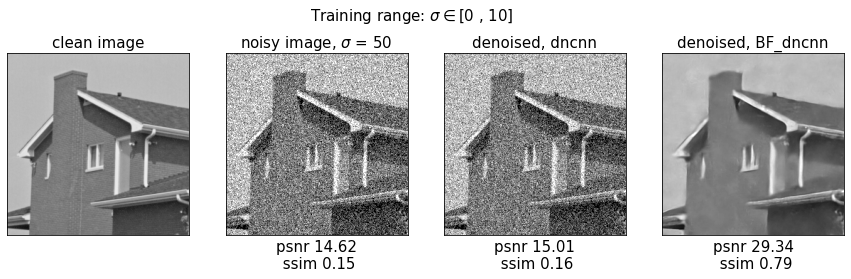

In [ ]:
# Denoise a noisy image (specify image by image_num, noise stdev by noise_level)
utils.display_denoising(CNN, BF_CNN, set12_path, l = min_noise, h = max_noise, model = model, image_num = 1, noise_level = 50)

In this example, the standard deviation of noise of the image is $\sigma=50$. The training set has noisy images whose maximum value is $\sigma = 10$. 
As could be expected, the denoising performed by the biased DnCNN network is not satisfactory, while the bias-free network was able to supress the noise.

#### Other Bias-free denoising experiments

We will denoise the *Simpson* image with the code provided by the authors. We  add noise to the original image and then try to remove it with the previous models loaded.

In [ ]:
# Load original image
original = plt.imread('../ffdnet-pytorch/simpson.png')

# Create noisy image
nrow,ncol = original.shape
sig = 50/255
noisy = original + sig*np.random.randn(nrow,ncol)
noisy_tensor = torch.from_numpy(noisy).unsqueeze(0).unsqueeze(0).to(device).float()

Denoising with a biased CNN

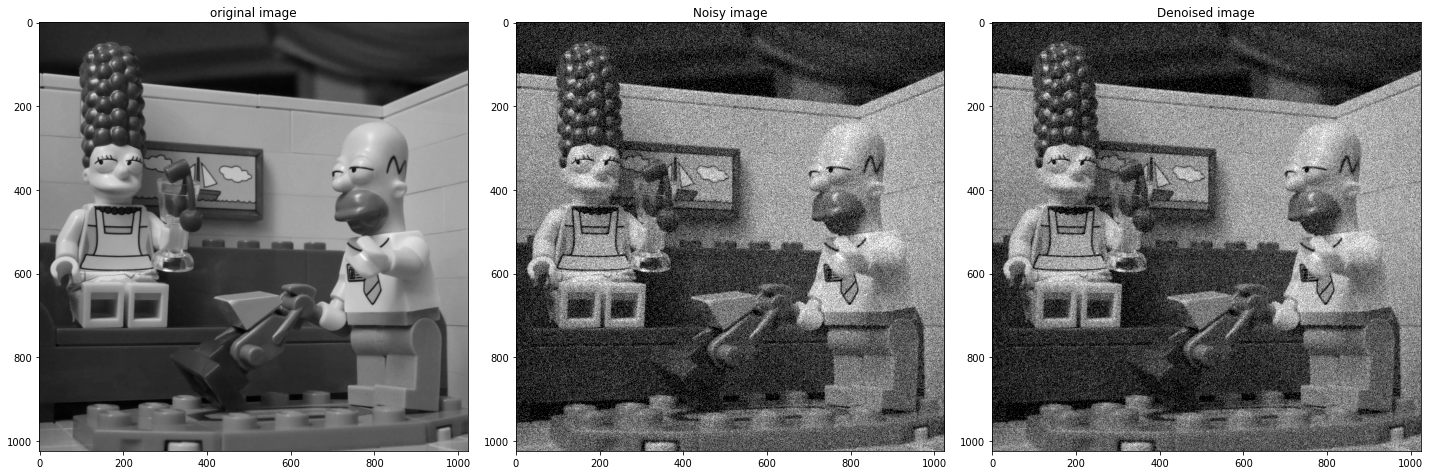

time:  0.024953365325927734
PSNR:  14.779722251490528


In [ ]:
# Denoise with biased CNN
start = time.time()
denoised_dncnn= CNN(noisy_tensor)
end = time.time()
denoised_dncnn = denoised_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()

printImages(original,noisy,denoised_dncnn)

# Print Statistics
print("time: ", end - start)
print("PSNR: ", PSNR(original, denoised_dncnn))

Denoising with bias-free CNN

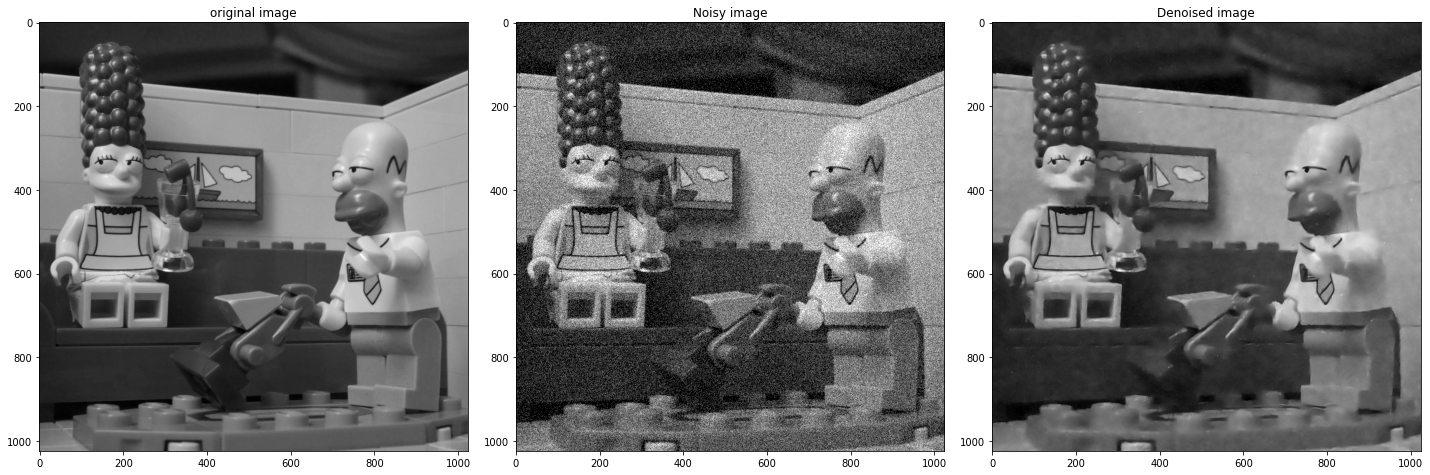

time:  0.00954127311706543
PSNR:  31.86379282428046


In [ ]:
# Denoise by bias-free CNN
start = time.time()
denoised_bf_dncnn= BF_CNN(noisy_tensor)
end = time.time()
denoised_bf_dncnn = denoised_bf_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()

printImages(original,noisy,denoised_bf_dncnn)

# Print Statistics
print("time: ", end - start)
print("PSNR: ", PSNR(original, denoised_bf_dncnn))

As in the previous experiment, the biased network fails to remove the noise, since the noise standard deviation of the image to be processed is outside the training range. However, the unbiased network is able to remove the noise quite efficiently.

#### Generalization capacity of bias-free networks

As we did before, we illustrate the behavior of the bias-free network within a wide range of noise levels. To this aim, we plot the PSNR of the denoised image for different noise levels $\sigma$, both inside and outside the training range. 

For the sake of comparison, we also plot the PSNR of the denoised image using a biased network for different noise levels $\sigma$.

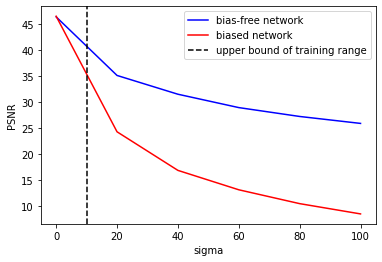

In [ ]:
psnr_list_bf = []
psnr_list = []
u = original[0:256,0:256]

for sigma in range(0, 120, 20):   
    noisy = u + (sigma/255)*np.random.randn(u.shape[0],u.shape[1])
    noisy_tensor = torch.from_numpy(noisy).unsqueeze(0).unsqueeze(0).to(device).float()
    # bias-free CNN
    denoised_bf_dncnn= BF_CNN(noisy_tensor)
    denoised_bf_dncnn = denoised_bf_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
    psnr_list_bf.append(PSNR(u, denoised_bf_dncnn))
    # biased CNN
    denoised_dncnn= CNN(noisy_tensor)
    denoised_dncnn = denoised_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()
    psnr_list.append(PSNR(u, denoised_dncnn))

# Plot data
plt.plot(range(0,120,20), psnr_list_bf, color='blue', label="bias-free network")
plt.plot(range(0,120,20), psnr_list, color='red', label="biased network")
plt.axvline(x=10, color='k', linestyle='--', label="upper bound of training range")
leg = plt.legend(loc='best', ncol=1, fancybox=True)
plt.xlabel('sigma')
plt.ylabel('PSNR')
plt.show()

As in the previous experiments, the higher the noise level, the lower the performance, regardless of the range $\sigma$. However, we observe that for noise levels outside the training range ($\sigma>10$ in this experiment), the bias-free networks perform better than the biased network. 



### Denoising mechanisms learned by bias free CNNs

An important contribution of the work [Mohan et al., Robust and interpretable blind image denoising via bias-free convolutional neural networks, 2020](https://arxiv.org/abs/1906.05478v3) is the study of the denoising mechanisms of BF-CNN (Bias free CNN). 

As explained before, the output of the network for a given input $y$ can be seen as: $f(y) = A_y y$, where $A_y$ is the Jacobian of $f(·)$ evaluated at input $y$. $A_y$ provides a local characterization of the denoising map, and this is what the paper analyzes. 


#### Adaptive filters

Considering an output pixel (i,j). This pixel is obtained by:

$$
f(y)(i,j) = \sum_{k=0}^{N} A_y(i,k)y(k,j)
$$

The $A_y$ rows can be seen as filters that produce a denoised pixel via a weighted average of original noisy pixels of $y$. It is important to note that $A_y$ depends also of the input $y$, it is an adaptive filter, learned from the data. 


### Projections onto low-dimensional adaptive subspaces

If we do the singular value decomposition of $A_y$, we have:

$$
f(y) = A_y y = USV^T y = \sum_{i=0}^{N} s_i (V_i^T y)U_i.
$$

The output is a linear combination of the left singular vectors ($U_i$), each weighted by the projection of the input onto the corresponding right singular vector ($V_i^T y$), and scaled by the corresponding singular value ($s_i$).

By analyzing these values ​​over ten images, the work shows that singular vectors corresponding to non-negligible singular values are approximately the same and seen to capture features of the input image. The network therefore implements an approximate projection onto an adaptive signal subspace which preserves the structure of the image, while suppressing noise. When the signal subspace is examined, a clean image lies almost entirely within it.